### Future Team Prediction
Predict the future team of a driver based on past team transitions and transfer trends.


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the processed integrated data
data = pd.read_csv('../../data/processed/fully_integrated_data.csv')

# Sort data by driver and season to ensure sequential ordering
data.sort_values(["driverId", "season"], inplace=True)

# Create a column for the next team/constructor for each driver based on time (future team prediction)
data['next_constructor'] = data.groupby('driverId')['constructorName'].shift(-1)

# Drop rows where there is no future team info (i.e. the last season per driver)
df = data.dropna(subset=['next_constructor'])

# Select feature columns that might have an impact on future team choice.
# Feel free to add more features or adjust as necessary.
features = [
    'season',
    'driverStartGridPos',
    'driverFinalGridPos',
    'driverFinalRank',
    'driverRacePoints',
    'driverLapCount',
    'constructorName'
]
target = 'next_constructor'

# Filter for the selected features and target, and drop any remaining missing values.
df = df[features + [target]].dropna()

# Encode categorical features:
# Encode the current team (constructorName) as a feature.
le_constructor = LabelEncoder()
df['constructorName_enc'] = le_constructor.fit_transform(df['constructorName'])

# Encode the target future team
le_target = LabelEncoder()
df['next_constructor_enc'] = le_target.fit_transform(df[target])

# Define X (features) and y (target) for the model
X = df[['season',
        'driverStartGridPos',
        'driverFinalGridPos',
        'driverFinalRank',
        'driverRacePoints',
        'driverLapCount',
        'constructorName_enc']]
y = df['next_constructor_enc']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

# Define a function to predict the future team of a driver based on new race data.
def predict_future_team(new_data):

    new_data_df = pd.DataFrame([new_data])
    # Encode the constructorName feature using the same label encoder used during training
    new_data_df['constructorName_enc'] = le_constructor.transform(new_data_df['constructorName'])
    X_new = new_data_df[['season',
                         'driverStartGridPos',
                         'driverFinalGridPos',
                         'driverFinalRank',
                         'driverRacePoints',
                         'driverLapCount',
                         'constructorName_enc']]
    pred_enc = rf.predict(X_new)
    pred_team = le_target.inverse_transform(pred_enc)
    return pred_team[0]



Model Accuracy: 0.8963320463320463


Classification Report:
                           precision    recall  f1-score   support

                      AFM       0.00      0.00      0.00         1
                      AGS       0.92      0.83      0.87        29
                      ATS       0.96      0.86      0.91        28
               Alfa Romeo       0.92      0.93      0.93        87
               AlphaTauri       0.94      1.00      0.97        30
           Alpine F1 Team       0.97      0.97      0.97        30
                     Alta       0.00      0.00      0.00         1
                     Amon       0.00      0.00      0.00         1
              Andrea Moda       1.00      1.00      1.00         3
                  Apollon       0.93      0.94      0.94       117
                   Arrows       0.00      0.00      0.00         1
        Aston Butterworth       0.97      0.81      0.88        42
             Aston Martin       0.95      0.95      0.95        41
                      BAR       0.00  

c:\Users\yeshw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:2687: UserWarning: labels size, 149, does not match size of target_names, 189
  warnings.warn(
c:\Users\yeshw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yeshw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yeshw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classif

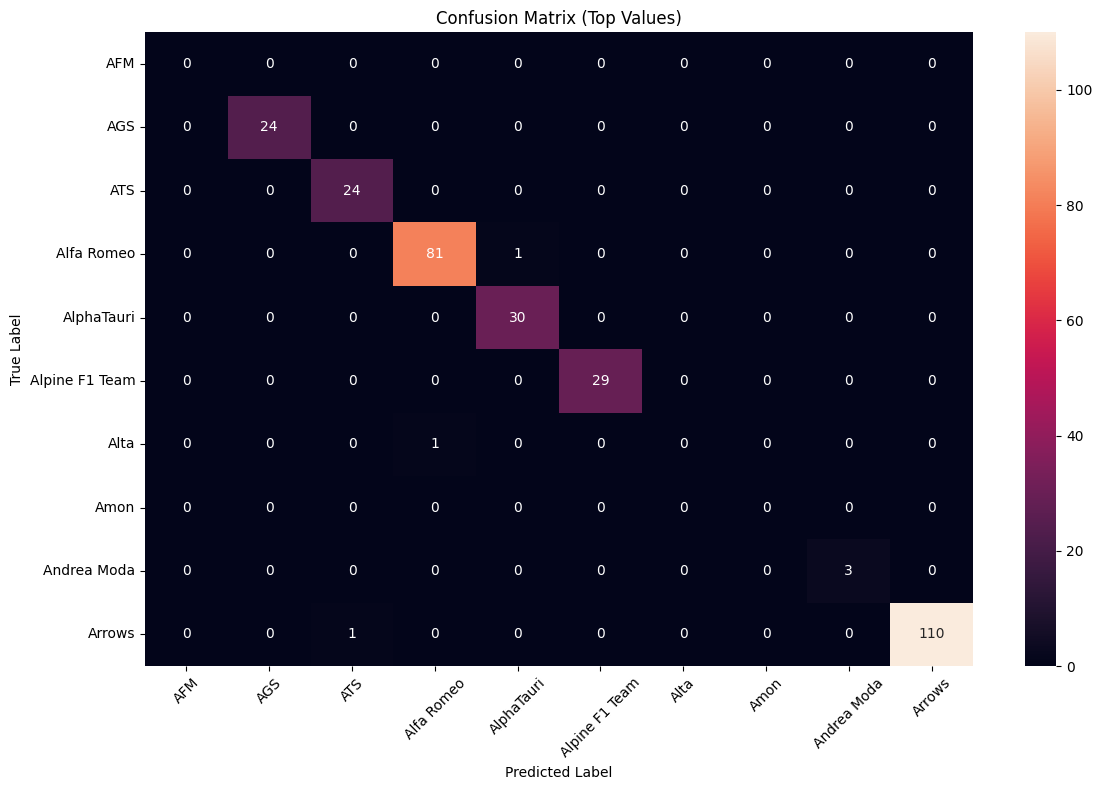

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Detailed model evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, 
      target_names=le_target.classes_, labels=np.unique(y_test)))

# Visualize confusion matrix
# Get the top values from the confusion matrix
top_values = np.unique(y_test)[:10]  # Adjust the number of top values as needed

plt.figure(figsize=(12, 8))
cm_top = confusion_matrix(y_test, y_pred, labels=top_values)
sns.heatmap(cm_top, annot=True, fmt='d', xticklabels=le_target.classes_[top_values],
            yticklabels=le_target.classes_[top_values])
plt.title('Confusion Matrix (Top Values)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())
print("CV score std:", cv_scores.std())

c:\Users\yeshw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Cross-validation scores: [0.77837838 0.87818533 0.86833977 0.82969685 0.76462638]
Average CV score: 0.82384534066519
CV score std: 0.04591504981157651


In [1]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
                          param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best model
best_model = grid_search.best_estimator_

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
import joblib

# Save the model and label encoders
joblib.dump(rf, 'future_team_predictor.joblib')
joblib.dump(le_constructor, 'constructor_encoder.joblib')
joblib.dump(le_target, 'target_encoder.joblib')

NameError: name 'rf' is not defined